In [40]:
# Quilter Mayabay/MVO Example
#Inputs
# mu = [0.01, 0.02, 0.03]
# sigma = [0.05, 0.08, 0.12]
# Roe = [[1, 0.5, 0.3], [0.5, 1, 0.7], [0.3, 0.7, 1]]  # Use this Correl to compute Covar matrix

# Maximise: E(R) - (RA - Sigma * 0.005^2)

#MayaBay Optimiser Settings:
# LowerBound = [0, 0, 0.05]
# UpperBound = [0.25, 0.75, 1]
# NumPorts = 20
# OptimiserStartPointStepSize = 0.02
# TargetRisk = 0.09
# AssetStdErr = [0.005, 0.03, 0.05]
# AssetStdErrSkew = [0.0, -0.5, -1]
# AssetStdErrSkew = [3.5, 3, 4]
# RandomSeedForReturns = 10;
# nScenarios = 10000;

#Outputs
# MVO Unconstrained = [0.0885, 0.3717, 0.5398]
# MVO TE Constrained = [0.0586, 0.4327, 0.5087]
# MayaBay Unconstrained = [0.0000, 0.5609, 0.4391]
# MayaBay TE Constrained = [0.0000, 0.5609, 0.4391]

# Code below taken from: https://nbviewer.jupyter.org/github/cvxgrp/cvx_short_course/blob/master/applications/portfolio_optimization.ipynb

In [47]:
# Generate data for long only portfolio optimization.
import numpy as np
import scipy.sparse as sp
np.random.seed(1)
n = 3
mu = np.array([[0.01], [0.02], [0.03]])
Sigma = np.random.randn(n, n)
Sigma = np.matmul(Sigma.T, Sigma)

In [48]:
mu

array([[0.01],
       [0.02],
       [0.03]])

In [51]:
Sigma

array([[ 6.83412762, -3.25042168,  2.16820864],
       [-3.25042168,  1.70261222, -1.91151145],
       [ 2.16820864, -1.91151145,  5.67783172]])

In [52]:
Sigma1

array([[ 6.83412762, -3.25042168,  2.16820864],
       [-3.25042168,  1.70261222, -1.91151145],
       [ 2.16820864, -1.91151145,  5.67783172]])

In [53]:
# Long only portfolio optimization.
import cvxpy as cp

w = cp.Variable(n)
gamma = cp.Parameter(nonneg=True)
ret = mu.T@w 
risk = cp.quad_form(w, Sigma)
prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
               [cp.sum(w) == 1, 
                w >= 0])

In [58]:
# Compute trade-off curve.
SAMPLES = 100
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
for i in range(SAMPLES):
    gamma.value = gamma_vals[i]
    prob.solve()
    risk_data[i] = cp.sqrt(risk).value
    ret_data[i] = ret.value

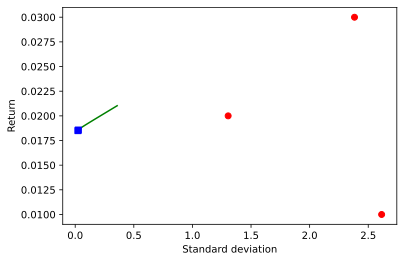

In [61]:
# Plot long only trade-off curve.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

markers_on = [29, 40]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, 'g-')
for marker in markers_on:
    plt.plot(risk_data[marker], ret_data[marker], 'bs')
    ax.annotate(r"$\gamma = %.2f$" % gamma_vals[marker], xy=(risk_data[marker]+.08, ret_data[marker]-.03))
for i in range(n):
    plt.plot(cp.sqrt(Sigma[i,i]).value, mu[i], 'ro')
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.show()

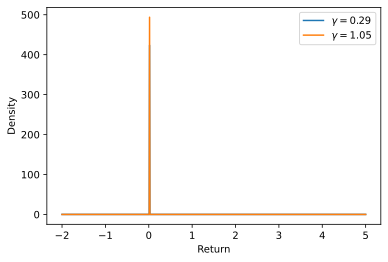

In [62]:
# Plot return distributions for two points on the trade-off curve.
import scipy.stats as spstats


plt.figure()
for midx, idx in enumerate(markers_on):
    gamma.value = gamma_vals[idx]
    prob.solve()
    x = np.linspace(-2, 5, 1000)
    plt.plot(x, spstats.norm.pdf(x, ret.value, risk.value), label=r"$\gamma = %.2f$" % gamma.value)

plt.xlabel('Return')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()

In [63]:
# Portfolio optimization with leverage limit.
Lmax = cp.Parameter()
prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
               [cp.sum(w) == 1, 
                cp.norm(w, 1) <= Lmax])

In [64]:
# Compute trade-off curve for each leverage limit.
L_vals = [1, 2, 4]
SAMPLES = 100
risk_data = np.zeros((len(L_vals), SAMPLES))
ret_data = np.zeros((len(L_vals), SAMPLES))
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
w_vals = []
for k, L_val in enumerate(L_vals):
    for i in range(SAMPLES):
        Lmax.value = L_val
        gamma.value = gamma_vals[i]
        prob.solve(solver=cp.SCS)
        risk_data[k, i] = cp.sqrt(risk).value
        ret_data[k, i] = ret.value

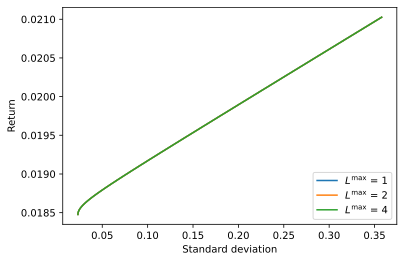

In [65]:
# Plot trade-off curves for each leverage limit.
for idx, L_val in enumerate(L_vals):
    plt.plot(risk_data[idx,:], ret_data[idx,:], label=r"$L^{\max}$ = %d" % L_val)
for w_val in w_vals:
    w.value = w_val
    plt.plot(cp.sqrt(risk).value, ret.value, 'bs')
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.legend(loc='lower right')
plt.show()

In [66]:
# Portfolio optimization with a leverage limit and a bound on risk.
prob = cp.Problem(cp.Maximize(ret), 
              [cp.sum(w) == 1, 
               cp.norm(w, 1) <= Lmax,
               risk <= 2])

In [67]:
# Compute solution for different leverage limits.
for k, L_val in enumerate(L_vals):
    Lmax.value = L_val
    prob.solve()
    w_vals.append( w.value )

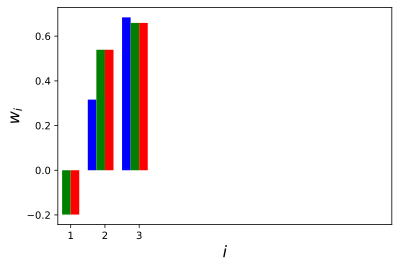

In [68]:
# Plot bar graph of holdings for different leverage limits.
colors = ['b', 'g', 'r']
indices = np.argsort(mu.flatten())
for idx, L_val in enumerate(L_vals):
     plt.bar(np.arange(1,n+1) + 0.25*idx - 0.375, w_vals[idx][indices], color=colors[idx], 
             label=r"$L^{\max}$ = %d" % L_val, width = 0.25)
plt.ylabel(r"$w_i$", fontsize=16)
plt.xlabel(r"$i$", fontsize=16)
plt.xlim([1-0.375, 10+.375])
plt.xticks(np.arange(1,n+1))
plt.show()

In [69]:
# Generate data for factor model.
n = 3000
m = 50
np.random.seed(1)
mu = np.abs(np.random.randn(n, 1))
Sigma_tilde = np.random.randn(m, m)
Sigma_tilde = Sigma_tilde.T.dot(Sigma_tilde)
D = sp.diags(np.random.uniform(0, 0.9, size=n))
F = np.random.randn(n, m)

In [70]:
# Factor model portfolio optimization.
w = cp.Variable(n)
f = cp.Variable(m)
gamma = cp.Parameter(nonneg=True)
Lmax = cp.Parameter()
ret = mu.T@w 
risk = cp.quad_form(f, Sigma_tilde) + cp.quad_form(w, D)
prob_factor = cp.Problem(cp.Maximize(ret - gamma*risk), 
                     [cp.sum(w) == 1,
                      f == F.T@w,
                      cp.norm(w, 1) <= Lmax])

# Solve the factor model problem.
Lmax.value = 2
gamma.value = 0.1
prob_factor.solve(verbose=True)

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Aug 10 03:52:56 PM: Your problem has 3050 variables, 3 constraints, and 2 parameters.
(CVXPY) Aug 10 03:52:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 10 03:52:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 10 03:52:56 PM: Compiling problem (target solver=OSQP).
(CVXPY) Aug 10 03:52:56 PM: Reduction chain: FlipObjective -> CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Aug 10 03:52:56 PM: Applying reduction FlipObjective
(CVXPY) Aug 10 03:52:56 PM: Applying reduct

4.60641308225902

In [71]:
# Standard portfolio optimization with data from factor model.
risk = cp.quad_form(w, F.dot(Sigma_tilde).dot(F.T) + D)
prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
               [cp.sum(w) == 1, 
                cp.norm(w, 1) <= Lmax])

# Uncomment to solve the problem.
# WARNING: this will take many minutes to run.
prob.solve(verbose=True)

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Aug 10 03:52:58 PM: Your problem has 3000 variables, 2 constraints, and 2 parameters.
(CVXPY) Aug 10 03:52:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 10 03:52:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 10 03:52:59 PM: Compiling problem (target solver=OSQP).
(CVXPY) Aug 10 03:52:59 PM: Reduction chain: FlipObjective -> CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Aug 10 03:52:59 PM: Applying reduction FlipObjective
(CVXPY) Aug 10 03:52:59 PM: Applying reduct

SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
print('Factor model solve time = {}'.format(prob_factor.solver_stats.solve_time))
print('Single model solve time = {}'.format(prob.solver_stats.solve_time))